#### MPAS Vertical interpolation
1) single level interpolation test
- Read MPAS cells
- Read MPAS data 
- interpolating the data from the model's vertical grid to a user-specified vertical grid using  np.interp for vertical interpolation assumes a log-linear relationship.
- Plotting 

2) Interpolating the data from the model's vertical grid to a user-specified  pressure levels

In [2]:
%matplotlib inline
 
import numpy as np
import xarray as xr

import matplotlib.collections as mplcollections
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.interpolate import griddata 

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
# from https://github.com/Unidata/python-training/blob/master/pages/gallery/Observational_Data_Cross_Section.ipynb
# The vertical interpolation assumes a log-linear relationship.
def vertical_interpolate(vcoord_data, interp_var, interp_levels):
    """A function to interpolate sounding data from each station to
    every millibar. Assumes a log-linear relationship.

    Input
    -----
    vcoord_data : A 1D array of vertical level values (e.g., pressure from a radiosonde)
    interp_var : A 1D array of the variable to be interpolated to all pressure levels
    interp_levels : A 1D array containing veritcal levels to interpolate to

    Return
    ------
    interp_data : A 1D array that contains the interpolated variable on the interp_levels
    """

    # Make veritcal coordinate data and grid level log variables
    lnp = np.log(vcoord_data)
    lnp_intervals = np.log(interp_levels)

    # Use numpy to interpolate from observed levels to grid levels
    interp_data = np.interp(lnp_intervals[::-1], lnp[::-1], interp_var[::-1])[::-1]

    # Mask for missing data (generally only near the surface)
    mask_low = interp_levels > vcoord_data[0]
    mask_high = interp_levels < vcoord_data[-1]
    interp_data[mask_low] = interp_var[0]
    interp_data[mask_high] = interp_var[-1]

    return interp_data


#### Read MPAS Cells

In [4]:
flnm_ini = '/gpfs/fs1/p/mmm/c3we/MPAS-Release-5.2/CLIM/2010/x1.40962.init.nc'
ds_i = xr.open_dataset(flnm_ini)
ds_i = ds_i.squeeze()

# Convert to degrees from radians
ds_i["lonCell"] = np.degrees(ds_i.lonCell)
ds_i["latCell"] = np.degrees(ds_i.latCell)

# For Global tripcolor plot
# Add cyclic point before computing the triangulation
ds_i["lonCell"] = ((ds_i["lonCell"] + 180) % 360) - 180

triang = tri.Triangulation(ds_i.lonCell, ds_i.latCell)

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'cfgrib.messages' has no attribute 'DEFAULT_INDEXPATH'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


##### Read and interpolate MPAS data  

In [8]:
# the variable to be interpolated 
var_s = 'theta'

# veritcal levels to interpolate to
p_1d = np.atleast_1d(50000) # hPa

flnm = '/gpfs/fs1/p/mmm/c3we/MPAS-Release-5.2/CLIM/2010/restart.2011-04-24_00.00.00.nc'
ds = xr.open_dataset(flnm)
ds = ds.squeeze()

theta = ds[var_s] #theta(nCells, nVertLevels)
pressure_b = ds.pressure_base # pressure_base(nCells, nVertLevels)
pressure_p = ds.pressure_p    # pressure_p(nCells, nVertLevels)
 
pres = pressure_b + pressure_p  #hPa
 
n_cell = theta.shape[0]
var_1d = np.empty((n_cell))

for nc in range(n_cell):
    var_1d[nc] = vertical_interpolate(pres[nc].values, theta[nc].values, p_1d)    

##### plotting

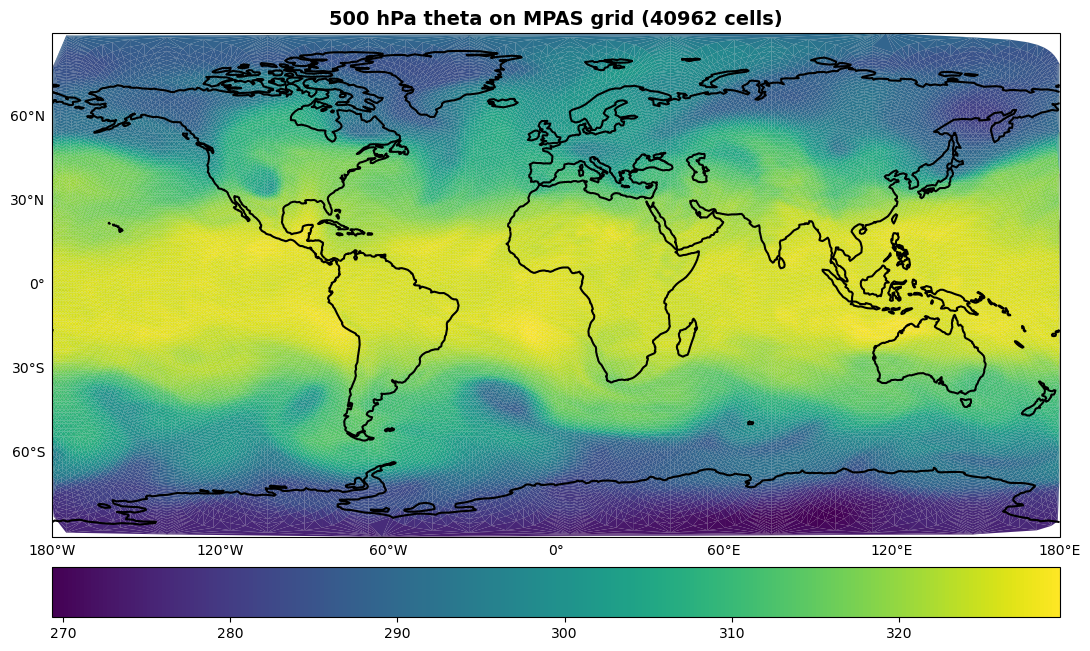

CPU times: user 5.61 s, sys: 76.9 ms, total: 5.69 s
Wall time: 5.91 s


In [14]:
%%time

fig = plt.figure(figsize=(13, 13))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
mm = ax.tripcolor(triang,
                  var_1d,
                  edgecolors='k',
                  lw=0.01,
                  alpha=1,
                  transform=ccrs.PlateCarree())
                  #cmap=c)
                  #vmin=55.0,
                  #vmax=100.)
ax.set_global()
ax.coastlines(lw=1.5, resolution='110m')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False
gl.xlines = gl.ylines = False
plt.colorbar(mm, orientation='horizontal', pad=0.03)
plt.title(str(int(p_1d[0]/100)) + " hPa theta on MPAS grid (" + str(len(ds_i.lonCell)) + " cells)",
          fontweight="bold",fontsize=14)
 
plt.show()

#### 2) Interpolating the data from the model's vertical grid to a user-specified pressure levels)

In [15]:
# veritcal levels to interpolate to
p_1d = np.atleast_1d(np.arange(1000, 50, -100)) # hPa
n_p = len(p_1d)

# vertic
var_2d = np.empty((n_p, n_cell))
for nc in range(n_cell):
    var_2d[:,nc] = vertical_interpolate(pres[nc].values, theta[nc].values, p_1d)    